# Cross-validation lung data
Does five-fold crossvalidation in annotating lung data to get stability of different algorithms

In [1]:
import os, sys

import anndata
import numpy as np
import scanpy as sc
from scanpy.plotting import palettes
import sys
sys.path.insert(0, '../../PopV')
import popv

From /home/cane/miniconda3/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:107: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
Created a temporary directory at /tmp/tmpu34427gp
Writing /tmp/tmpu34427gp/_remote_module_non_scriptable.py
Global seed set to 0


## Run PopV

In [2]:
thymus_fn = '../thymus_cv/data/Thymus_TS.h5ad'
thymus = sc.read_h5ad(thymus_fn)

In [3]:
query_index = np.random.choice([0,1,2,3,4], size = len(thymus), replace=True)

In [4]:
if not os.path.exists('data'):
    os.mkdir('data')

In [5]:
for i in range(0,5):
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    thymus[query_index!=i].write(ref_adata_path)
    thymus[query_index==i].write(query_adata_path)

In [6]:
save_folder = 'popv_results'
query_batch_key = 'donor_assay'

# Lesser used parameters
query_labels_key=None
unknown_celltype_label='unknown'

# Following parameters are specific to Tabula Sapiens dataset
ref_labels_key='cell_ontology_class'
ref_batch_key = 'donor_assay'

In [7]:
from popv.preprocessing import Process_Query
from popv.annotation import annotate_data

In [ ]:
for i in range(0,5):
    print(i)
    save_folder = f'cv_run_{i}/popv_results_{i}'
    if not os.path.exists(f'cv_run_{i}'):
        os.mkdir(f'cv_run_{i}')
    
    ref_adata_path = "data/ref_{}.h5ad".format(i)
    query_adata_path = "data/query_{}.h5ad".format(i)
    
    # read in the reference dataset
    ref_adata = anndata.read(ref_adata_path)
    query_adata = anndata.read(query_adata_path)
    
    min_celltype_size = np.min(ref_adata.obs.groupby('cell_ontology_class').size())
    n_samples_per_label = np.max((min_celltype_size, 100))
    
    adata = Process_Query(
        query_adata,
        ref_adata,
        query_labels_key=query_labels_key,
        query_batch_key=query_batch_key,
        ref_labels_key=ref_labels_key,
        ref_batch_key=ref_batch_key,
        unknown_celltype_label=unknown_celltype_label,
        save_path_trained_models=f'cv_run_{i}/pretrained_models/',
        cl_obo_folder='../../PopV/ontology/',
        pretrained_scvi_path=None,
        prediction_mode='retrain',
        n_samples_per_label=n_samples_per_label,
        use_gpu=True,
        compute_embedding=True,
        hvg=4000
    ).adata
    
    annotate_data(adata, save_path=save_folder)
    adata.write(f'cv_run_{i}/annotated_query.h5ad')

## Evaluate results

In [2]:
thymus_fn = '../thymus_cv/data/Thymus_TS.h5ad'
thymus = anndata.read(thymus_fn)

In [3]:
i = 0
query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
pred_keys = list(set(list(query.uns['prediction_keys']) + list(query.uns['prediction_keys_seen'])))

In [4]:
thymus.obs['cv_prediction'] = 'na'

for k in pred_keys:
    thymus.obs[k] = 'na'

thymus.obs['cv_idx'] = 'na'

In [5]:
names = []
for i in range(5):
    print(i)
    query = anndata.read('cv_run_{}/annotated_query.h5ad'.format(i))
    names.append(query.obs_names)
    thymus.obs.loc[query.obs_names, 'cv_prediction'] = query.obs['popv_prediction'].astype('str')
    thymus.obs.loc[query.obs_names, 'cv_idx'] = str(i)
    for k in pred_keys:
        thymus.obs.loc[query.obs_names, k] = query.obs[k].astype('str')

0
1
2
3
4


Making confusion matrix for cv_prediction


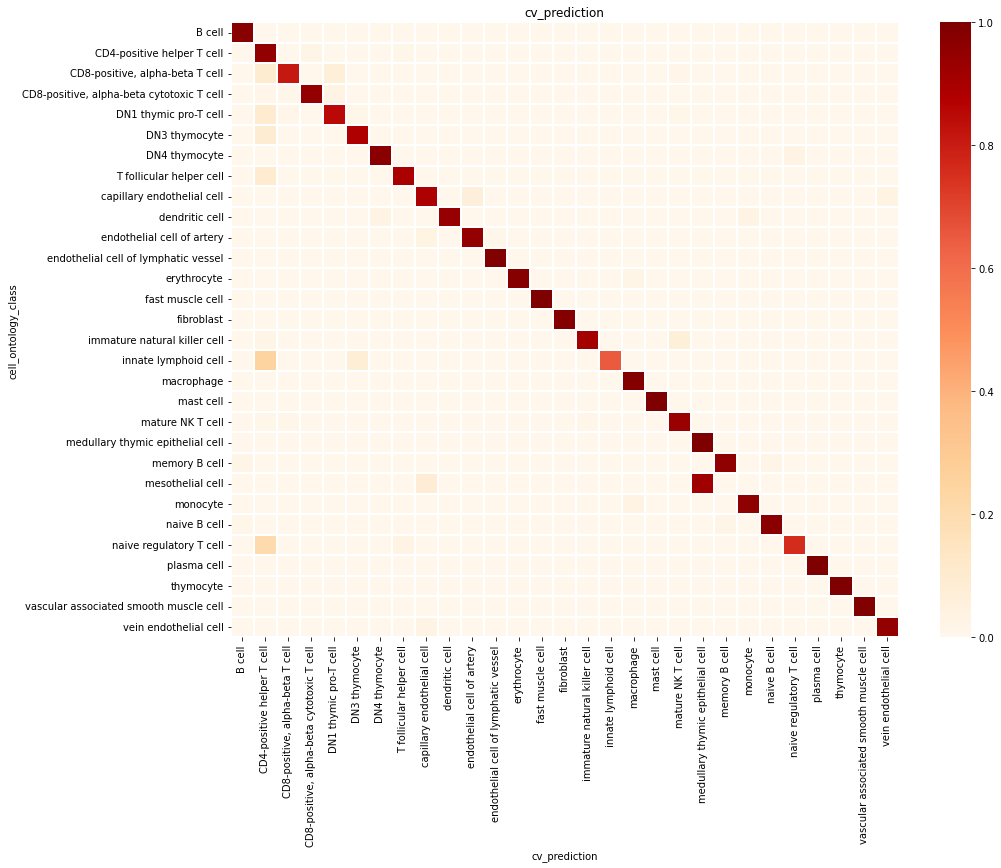

In [6]:
popv.visualization.make_agreement_plots(thymus, prediction_keys=['cv_prediction'], popv_prediction_key='cell_ontology_class', save_folder='.')

Making confusion matrix for popv_onclass_seen


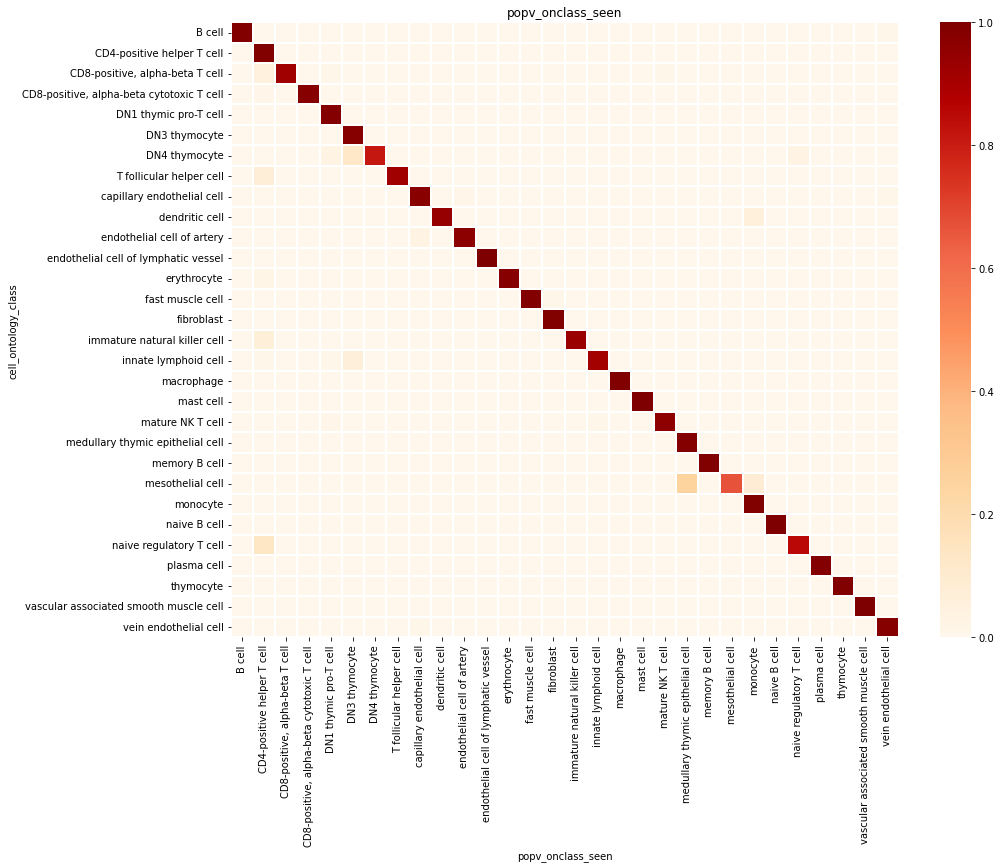

Making confusion matrix for popv_svm_prediction


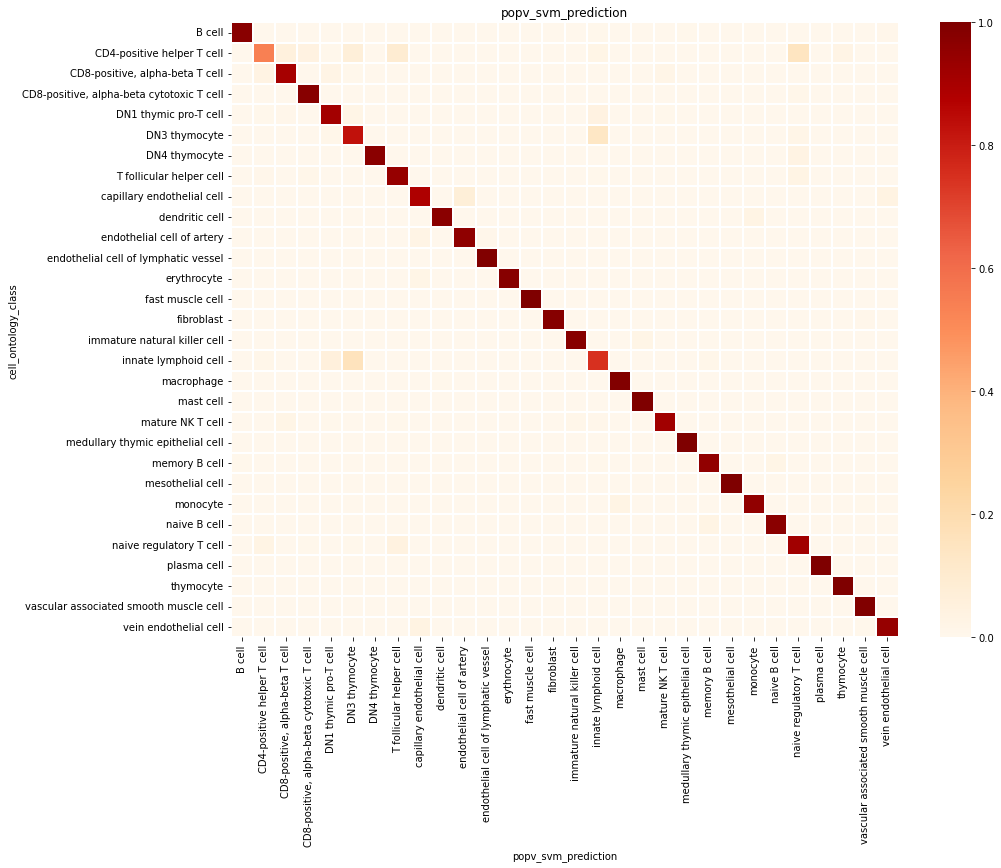

Making confusion matrix for popv_celltypist_prediction


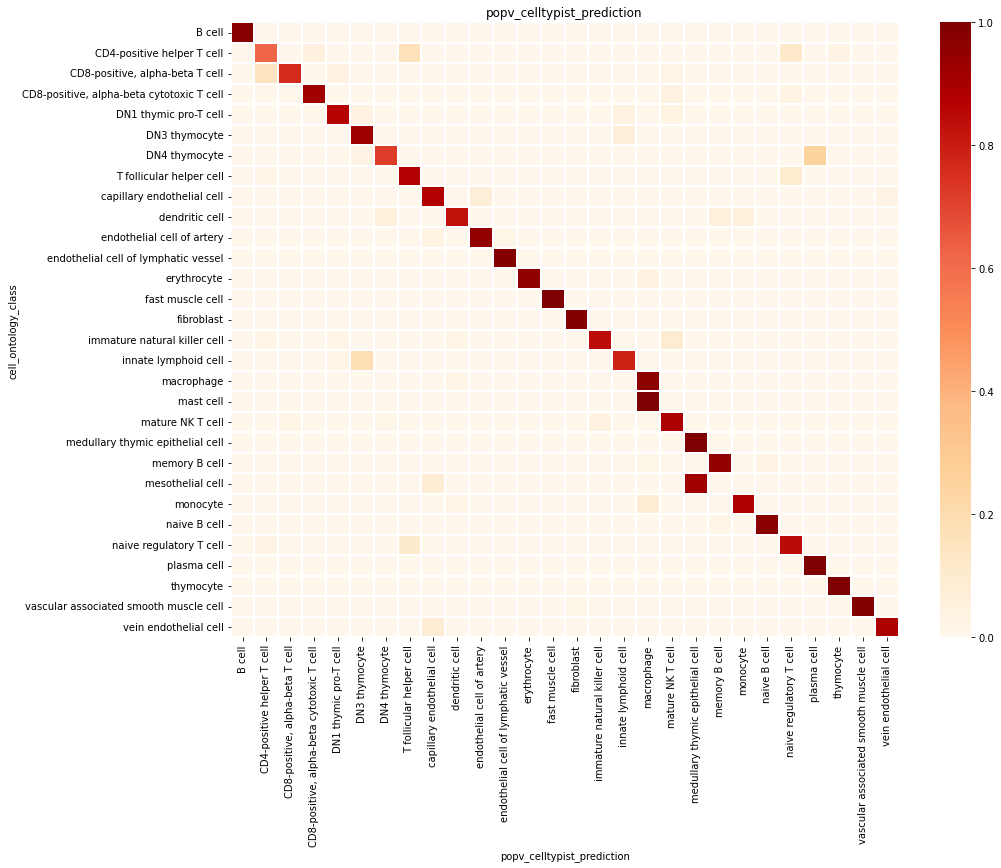

Making confusion matrix for popv_scanvi_prediction


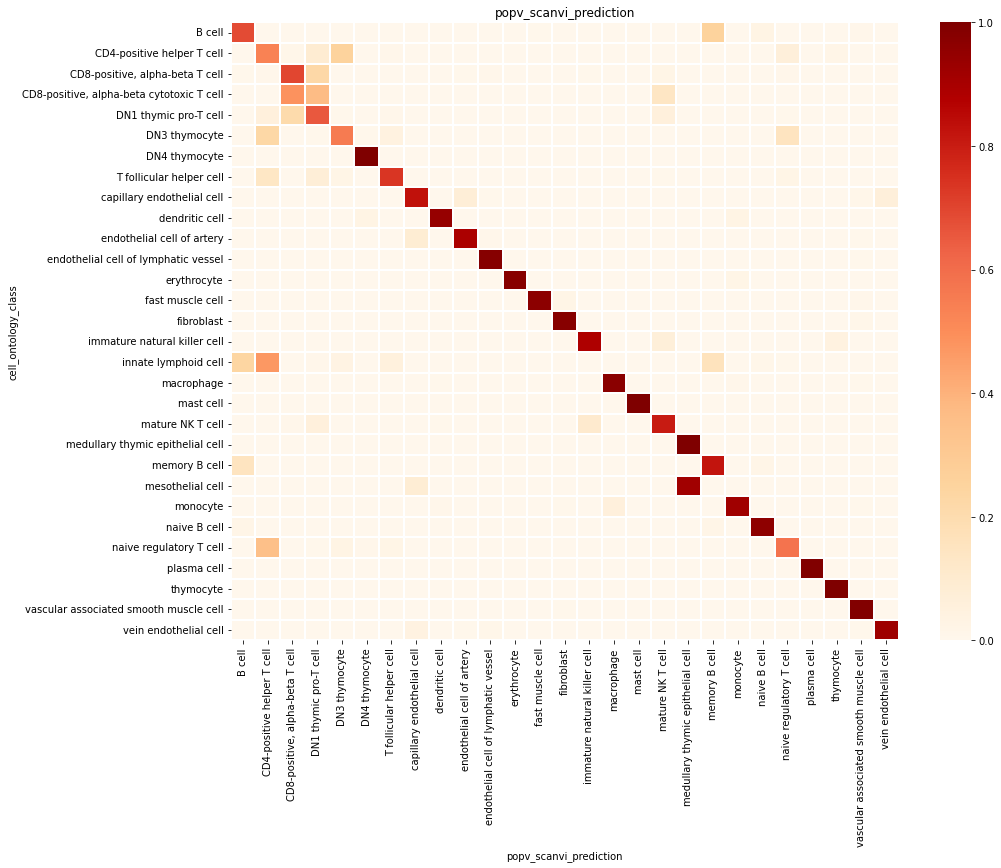

Making confusion matrix for popv_rf_prediction


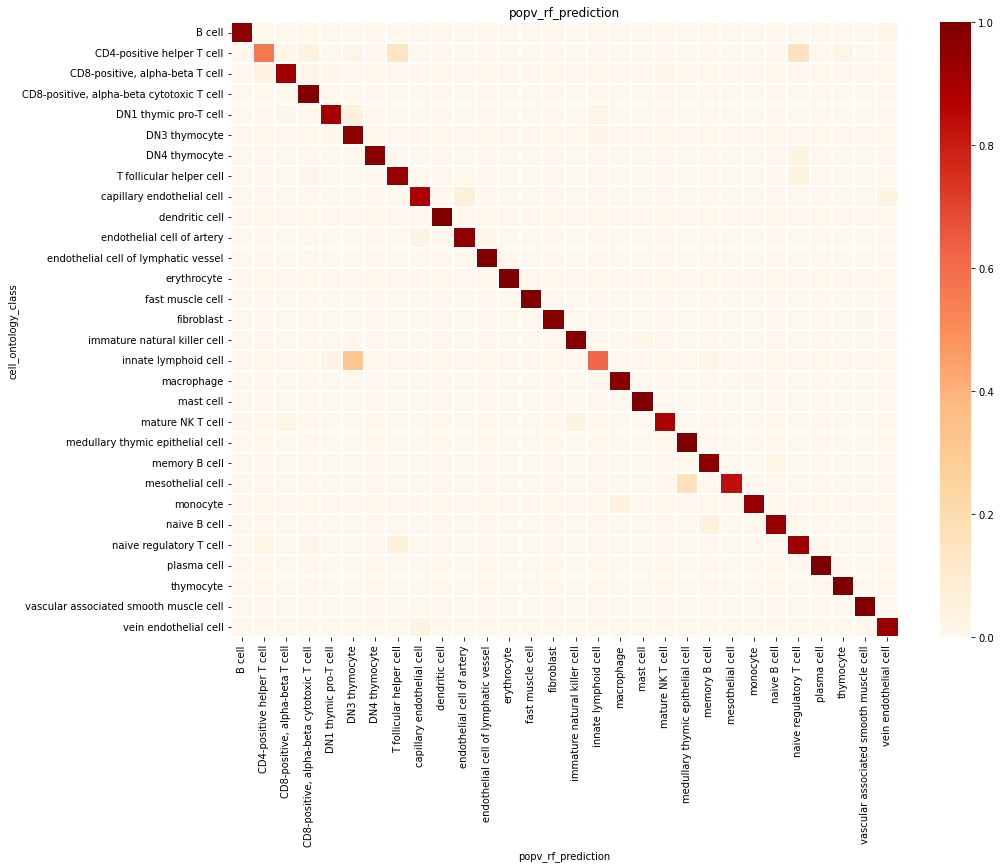

Making confusion matrix for popv_knn_on_scanorama_prediction


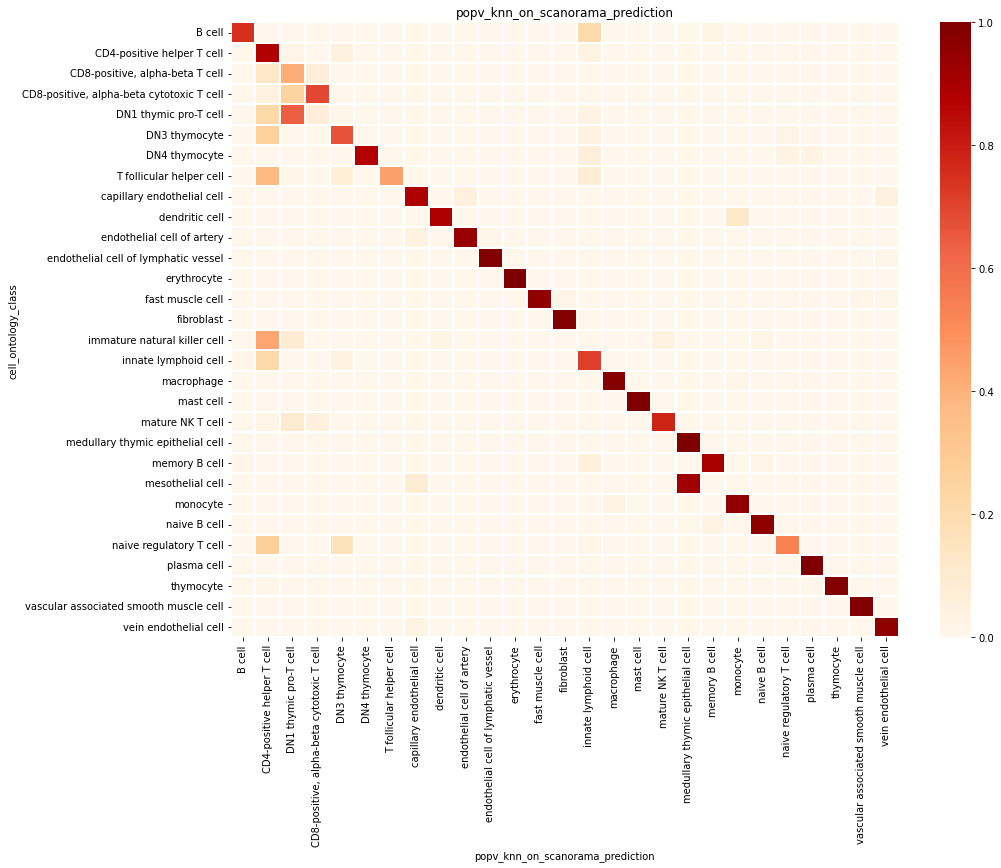

Making confusion matrix for popv_onclass_prediction


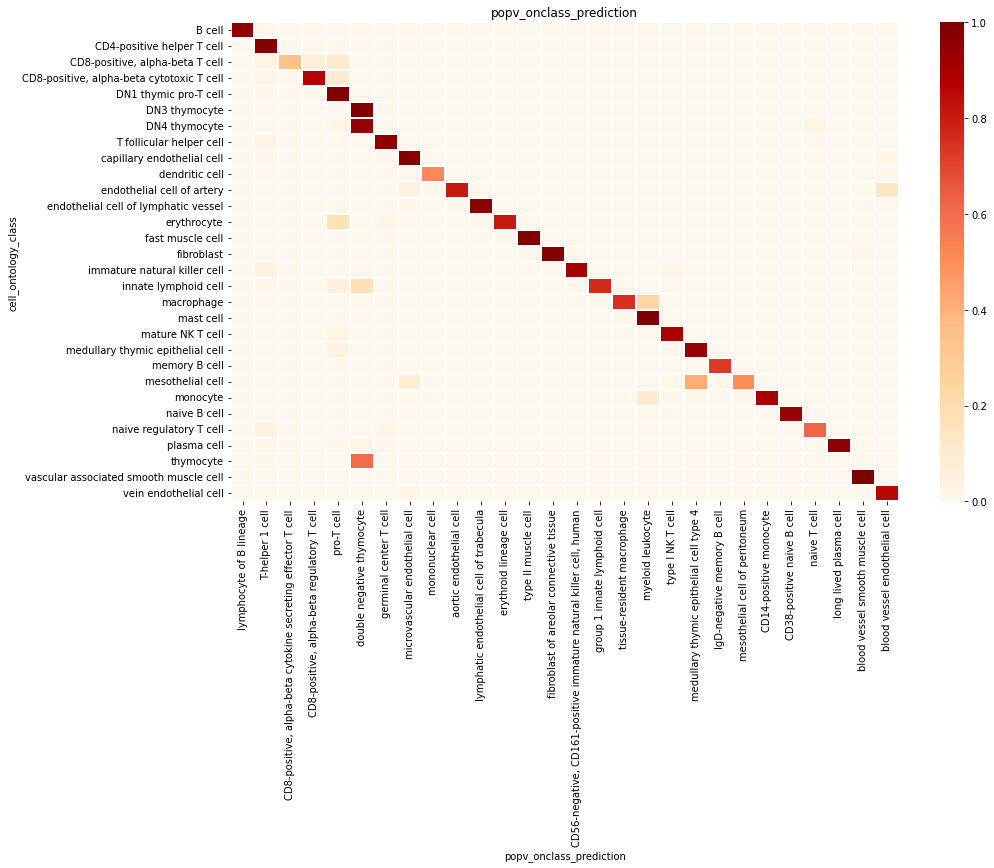

Making confusion matrix for popv_knn_on_scvi_prediction


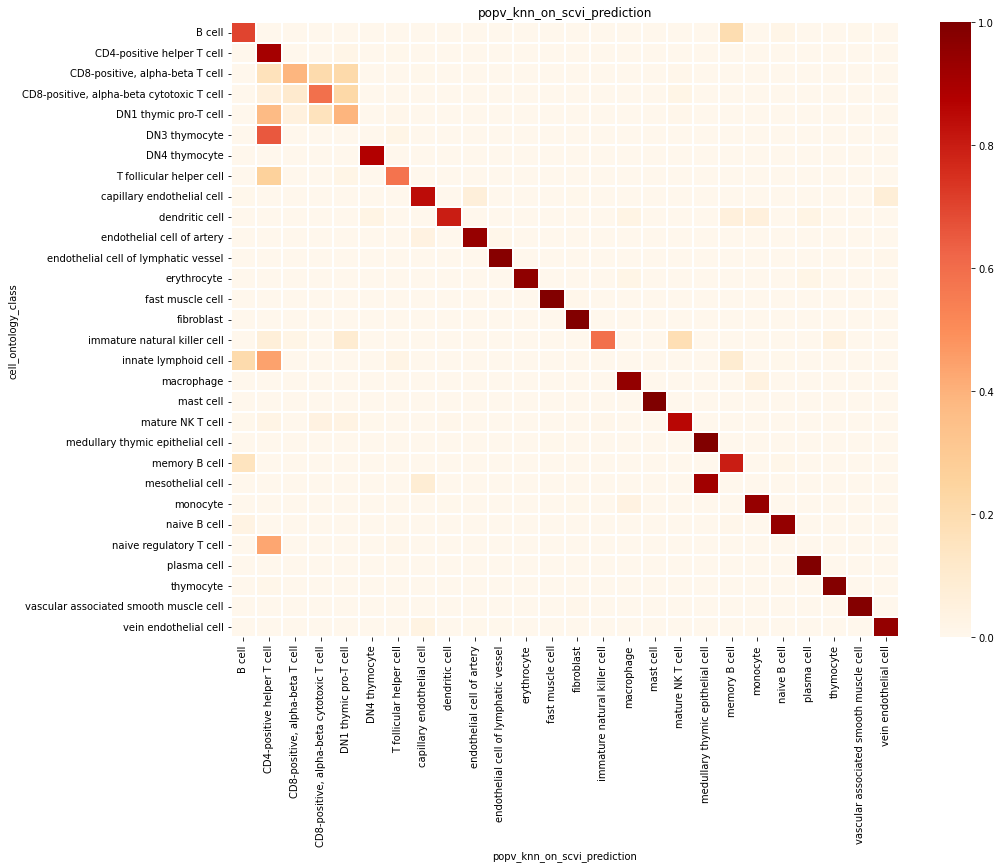

Making confusion matrix for popv_knn_on_bbknn_prediction


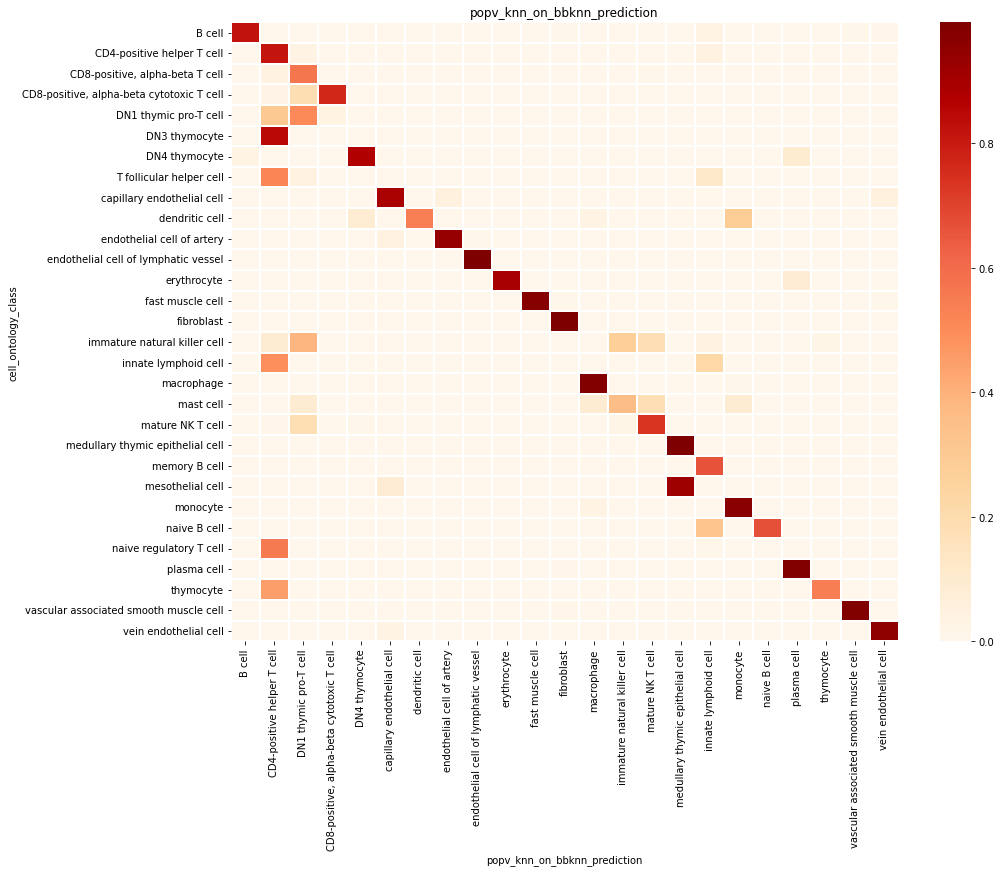

In [7]:
predictors = [i for i in thymus.obs.columns if 'popv' in i]
popv.visualization.make_agreement_plots(thymus, prediction_keys=predictors, popv_prediction_key='cell_ontology_class', save_folder='.')